# Using PCHIC data to validate SCARP regulatory score

In [1]:
from help_func import *
pd.set_option('display.max_columns', 500)

# Data preprocessing

## import ATAC data

In [2]:
ATAC_data = sc.read_h5ad('./Processed data/10X_pbmc_ATAC_celltype_filtered_CD4_Naive.h5ad')

In [3]:
ATAC_peaks = ATAC_data.var
ATAC_peaks

,peak,gene,distance,peak_type,chr,from,to,n_cells
chr1:10109-10357,chr1:10109-10357,MIR1302-2HG,-19197,distal,chr1,10109,10357,6
chr1:180730-181630,chr1:180730-181630,AL627309.5,-6869,distal,chr1,180730,181630,19
chr1:191491-191736,chr1:191491-191736,AL627309.5,-17630,distal,chr1,191491,191736,3
chr1:267816-268196,chr1:267816-268196,AP006222.2,962,distal,chr1,267816,268196,12
chr1:586028-586373,chr1:586028-586373,AC114498.1,-1256,distal,chr1,586028,586373,10
...,...,...,...,...,...,...,...,...
chrX:155880572-155882091,chrX:155880572-155882091,VAMP7,0,promoter,chrX,155880572,155882091,201
chrX:155966975-155967181,chrX:155966975-155967181,IL9R,-30400,distal,chrX,155966975,155967181,4
chrX:155997360-155997882,chrX:155997360-155997882,IL9R,0,promoter,chrX,155997360,155997882,9
chrY:11332988-11334144,chrY:11332988-11334144,NaN,NaN,intergenic,chrY,11332988,11334144,5


In [4]:
ATAC_promoters = ATAC_peaks[ATAC_peaks['peak_type'] == 'promoter'][['peak', 'chr', 'from', 'to']]
ATAC_promoters

,peak,chr,from,to
chr1:777634-779926,chr1:777634-779926,chr1,777634,779926
chr1:816881-817647,chr1:816881-817647,chr1,816881,817647
chr1:869449-870383,chr1:869449-870383,chr1,869449,870383
chr1:903617-907386,chr1:903617-907386,chr1,903617,907386
chr1:920493-926443,chr1:920493-926443,chr1,920493,926443
...,...,...,...,...
chrX:155262922-155264853,chrX:155262922-155264853,chrX,155262922,155264853
chrX:155611306-155613309,chrX:155611306-155613309,chrX,155611306,155613309
chrX:155767383-155767733,chrX:155767383-155767733,chrX,155767383,155767733
chrX:155880572-155882091,chrX:155880572-155882091,chrX,155880572,155882091


## import PCHIC data

In [5]:
pcHiC_data = pd.read_table(
    "./Raw data/PCHiC_peak_matrix_cutoff5.tsv",
    usecols=["baitChr", "baitStart", "baitEnd", "baitID", 'baitName',
             "oeChr", "oeStart", "oeEnd", "oeID", "oeName", "nCD4"], 
    dtype={"baitID": str, "oeID": str, 'baitChr': str, 'oeChr': str}
)
pcHiC_data = pcHiC_data[pcHiC_data["nCD4"]>5]
pcHiC_data.columns = ["baitChr", "baitSt", "baitEnd", "baitID", 'baitName',
                      "oeChr", "oeSt", "oeEnd", "oeID", 'oeName', "nCD4"]

In [6]:
help_list = list(pcHiC_data['baitChr'])
pcHiC_data['baitChr'] = ['chr' + str(help_list[i]) for i in range(pcHiC_data.shape[0])]

In [7]:
help_list = list(pcHiC_data['oeChr'])
pcHiC_data['oeChr'] = ['chr' + str(help_list[i]) for i in range(pcHiC_data.shape[0])]

In [8]:
pcHiC_promoters = pcHiC_data.drop_duplicates(subset=['baitID'], 
                                             keep='first', 
                                             inplace=False, 
                                             ignore_index=False)[
    ['baitChr', 'baitSt', 'baitEnd', 'baitID', 'baitName']]
pcHiC_promoters.index = pcHiC_promoters['baitID']
pcHiC_promoters

,baitChr,baitSt,baitEnd,baitID,baitName
baitID,,,,,
218,chr1,831895,848168,218,RP11-54O7.16;RP11-54O7.1
223,chr1,889424,903640,223,KLHL17;NOC2L;PLEKHN1
224,chr1,903641,927394,224,C1orf170;PLEKHN1
225,chr1,927395,936954,225,HES4;RP11-54O7.17
228,chr1,943677,957199,228,AGRN;ISG15;RP11-54O7.11
...,...,...,...,...,...
833137,chrY,15809473,15825594,833137,TMSB4Y
835021,chrY,21716817,21732795,835021,TXLNG2P
835094,chrY,21905989,21911308,835094,KDM5D


In [9]:
pcHiC_oe = pcHiC_data.drop_duplicates(subset=['oeID'], 
                                      keep='first', 
                                      inplace=False, 
                                      ignore_index=False)[
    ['oeChr', 'oeSt', 'oeEnd', 'oeID', 'oeName']]
pcHiC_oe.index = pcHiC_oe['oeID']
pcHiC_oe

,oeChr,oeSt,oeEnd,oeID,oeName
oeID,,,,,
220,chr1,850619,874081,220,AL645608.1;RP11-54O7.3;SAMD11
254,chr1,1206874,1212438,254,RP5-902P8.10;UBE2J2
251,chr1,1150970,1156235,251,.
256,chr1,1220555,1239425,256,.
257,chr1,1239426,1278099,257,ACAP3;CPSF3L;GLTPD1;PUSL1;RP5-890O3.9;TAS1R3
...,...,...,...,...,...
835530,chrY,23416074,23423341,835530,.
835531,chrY,23423342,23424529,835531,.
835532,chrY,23424530,23428951,835532,.


## Aligning promoters of scATAC and baits of pcHIC

In [10]:
ATAC_promoters_append_PCHIC_promoter = pd.DataFrame()

for temp_atac_pro in ATAC_promoters.index:
    # search in same chromosome
    temp_pchic_pro_df = pcHiC_promoters[pcHiC_promoters['baitChr']
                                        == ATAC_promoters['chr'].loc[temp_atac_pro]]

    res_list = []
    for temp_pchic_pro in temp_pchic_pro_df.index:
        res = is_pchic_validated(int(ATAC_promoters['from'].loc[temp_atac_pro]),
                                 int(ATAC_promoters['to'].loc[temp_atac_pro]),
                                 int(temp_pchic_pro_df['baitSt'].loc[temp_pchic_pro]),
                                 int(temp_pchic_pro_df['baitEnd'].loc[temp_pchic_pro]),
                                 thre1=0.5,
                                 thre2=5000)
        res_list.append(res)
        # have corresponding promoter
        if res == 1:
            ATAC_promoters_append_PCHIC_promoter = pd.concat([ATAC_promoters_append_PCHIC_promoter,
                pd.DataFrame(temp_pchic_pro_df[['baitChr', 'baitSt', 'baitEnd', 'baitID']].loc[temp_pchic_pro]).T])
            break

    # haven't corresponding promoter
    if sum(res_list) == 0:
        ATAC_promoters_append_PCHIC_promoter = pd.concat([ATAC_promoters_append_PCHIC_promoter,
            pd.DataFrame(np.zeros((1, 4)), columns=['baitChr', 'baitSt', 'baitEnd', 'baitID'])])

ATAC_promoters_append_PCHIC_promoter.index = ATAC_promoters.index
ATAC_promoters = ATAC_promoters.join(ATAC_promoters_append_PCHIC_promoter)

In [11]:
ATAC_promoters_append_PCHIC_promoter

,baitChr,baitSt,baitEnd,baitID
chr1:777634-779926,0.0,0.0,0.0,0.0
chr1:816881-817647,0.0,0.0,0.0,0.0
chr1:869449-870383,0.0,0.0,0.0,0.0
chr1:903617-907386,chr1,903641,927394,224
chr1:920493-926443,chr1,903641,927394,224
...,...,...,...,...
chrX:155262922-155264853,0.0,0.0,0.0,0.0
chrX:155611306-155613309,0.0,0.0,0.0,0.0
chrX:155767383-155767733,0.0,0.0,0.0,0.0
chrX:155880572-155882091,0.0,0.0,0.0,0.0


## Filtering pcHIC data based on aligned promoters

In [12]:
ATAC_promoters = ATAC_promoters[ATAC_promoters['baitID'] != 0]
pcHiC_promoters = pcHiC_promoters.loc[ATAC_promoters['baitID']]
pcHiC_data = pcHiC_data[pcHiC_data['baitID'].isin(ATAC_promoters['baitID'])]

In [13]:
pcHiC_data.insert(pcHiC_data.shape[1], 'value', np.ones(pcHiC_data.shape[0]))
PCHIC_judge_mat = pd.pivot(pcHiC_data, index='baitID', columns='oeID', values='value')
PCHIC_judge_mat = PCHIC_judge_mat.fillna(0)
PCHIC_judge_mat = PCHIC_judge_mat.loc[ATAC_promoters['baitID']]
PCHIC_judge_mat.shape

(1308, 11919)

In [14]:
pcHiC_oe = pcHiC_oe[pcHiC_oe['oeID'].isin(PCHIC_judge_mat.columns)]
pcHiC_oe.index = pcHiC_oe['oeID']
pcHiC_oe

,oeChr,oeSt,oeEnd,oeID,oeName
oeID,,,,,
220,chr1,850619,874081,220,AL645608.1;RP11-54O7.3;SAMD11
254,chr1,1206874,1212438,254,RP5-902P8.10;UBE2J2
251,chr1,1150970,1156235,251,.
256,chr1,1220555,1239425,256,.
257,chr1,1239426,1278099,257,ACAP3;CPSF3L;GLTPD1;PUSL1;RP5-890O3.9;TAS1R3
...,...,...,...,...,...
829778,chrX,153715829,153719991,829778,SLC10A3
829707,chrX,153284528,153289468,829707,IRAK1;MIR718
829710,chrX,153295730,153297711,829710,.


## Aligning peaks of scATAC and oes of pcHIC

In [15]:
ATAC_peaks_append_PCHIC_oe = pd.DataFrame()

for temp_peak in ATAC_peaks.index:
    # search in same chromosome
    temp_PCHIC_oe_df = pcHiC_oe[pcHiC_oe['oeChr']
                                == ATAC_peaks['chr'].loc[temp_peak]]

    res_list = []
    for temp_oe in temp_PCHIC_oe_df.index:
        res = is_pchic_validated(int(ATAC_peaks['from'].loc[temp_peak]),
                                 int(ATAC_peaks['to'].loc[temp_peak]),
                                 int(temp_PCHIC_oe_df['oeSt'].loc[temp_oe]),
                                 int(temp_PCHIC_oe_df['oeEnd'].loc[temp_oe]),
                                 thre1=0.5,
                                 thre2=5000)
        res_list.append(res)
        # have corresponding peak
        if res == 1:
            ATAC_peaks_append_PCHIC_oe = pd.concat([ATAC_peaks_append_PCHIC_oe,
                pd.DataFrame(pcHiC_oe[['oeChr', 'oeSt', 'oeEnd', 'oeID']].loc[temp_oe]).T])
            break

    # haven't corresponding peak
    if sum(res_list) == 0:
        ATAC_peaks_append_PCHIC_oe = pd.concat([ATAC_peaks_append_PCHIC_oe,
            pd.DataFrame(np.zeros((1, 4)), columns=['oeChr', 'oeSt', 'oeEnd', 'oeID'])])


In [16]:
ATAC_peaks_append_PCHIC_oe.index = ATAC_peaks.index
ATAC_peaks = ATAC_peaks.join(ATAC_peaks_append_PCHIC_oe)

## Filtering peaks validated by pcHIC

In [17]:
ATAC_peaks = ATAC_peaks[ATAC_peaks['oeID'] != 0]
pcHiC_oe = pcHiC_oe.loc[ATAC_peaks['oeID']]
pcHiC_data = pcHiC_data[pcHiC_data['oeID'].isin(ATAC_peaks['oeID'])]

In [18]:
PCHIC_judge_mat = PCHIC_judge_mat[ATAC_peaks['oeID']]
PCHIC_judge_mat.shape

(1308, 4631)

# SCARP regulatory scores

## import peaks embedding of SCARP and compute cos similarity

In [19]:
SCARP_peaks_embedding = pd.read_csv(
    './Results/10X_pbmc_ATAC_celltype_filtered_CD4_Naive_SCARP_Peaks_feature.csv', index_col=0)
print(SCARP_peaks_embedding.shape)
SCARP_peaks_embedding.head(5)

(101472, 40)


,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature23,feature24,feature25,feature26,feature27,feature28,feature29,feature30,feature31,feature32,feature33,feature34,feature35,feature36,feature37,feature38,feature39,feature40
chr1:10109-10357,0.980152,-0.156245,0.011708,0.004244,0.001702,-0.000424,-0.002955,0.018375,0.001959,-0.005383,0.022842,-0.019200,0.010854,0.010547,0.000836,-0.005845,0.004317,0.011002,0.011628,-0.016792,-0.030438,-0.017384,-0.005249,0.006253,-0.009618,-0.019886,-0.011183,-0.017834,0.012692,-0.004041,0.023480,0.013982,0.028092,0.003976,0.043012,-0.000586,0.042138,-0.033758,0.027627,-0.056189
chr1:180730-181630,0.589978,0.164716,-0.050329,0.019330,0.050012,-0.014221,0.137434,0.217240,-0.378305,-0.162718,0.011663,-0.063644,0.074035,-0.250748,0.322809,0.043447,-0.064859,-0.048159,0.000261,-0.023379,0.011144,0.041467,0.015905,-0.037453,0.011647,-0.027990,-0.000994,-0.020913,0.075657,-0.051050,0.058839,-0.103112,0.409711,0.045243,0.005925,-0.002411,0.018377,-0.008379,-0.007892,-0.010022
chr1:191491-191736,0.211096,0.163135,0.020014,-0.029840,0.029039,0.003635,0.072961,0.062153,0.069488,0.020919,0.127664,-0.228175,0.066696,-0.146859,-0.027355,-0.373933,0.574363,-0.472348,0.035924,-0.133857,-0.017281,-0.225915,-0.055426,0.014278,-0.032925,-0.180142,-0.017128,-0.075444,0.049703,0.022271,0.037051,0.012482,-0.069377,0.018816,-0.001101,0.013348,0.020097,0.011871,0.002916,-0.023068
chr1:267816-268196,0.601740,0.027406,0.001507,0.001261,0.007897,-0.000534,0.030930,0.027972,0.043334,-0.007179,0.037691,-0.038771,0.026361,-0.008394,0.034854,-0.017491,0.041701,0.005239,0.019845,0.041393,-0.002501,0.063825,-0.004445,-0.049327,0.026062,-0.008493,-0.021887,0.047613,0.106725,-0.124128,0.100468,-0.214220,0.726851,0.038907,-0.035526,0.013879,0.009133,0.006352,-0.005816,-0.009414
chr1:586028-586373,0.490054,-0.032125,0.006648,-0.009752,-0.008309,-0.007038,0.003847,0.010839,0.002022,-0.009170,-0.002286,-0.000807,-0.000367,-0.001081,0.001889,-0.013327,-0.013325,0.004942,-0.011567,-0.016318,-0.007197,-0.009595,-0.002320,-0.014374,-0.008583,-0.024534,0.002600,-0.010836,0.012389,-0.002670,-0.004130,0.004923,0.001650,-0.010642,-0.023407,0.018152,-0.864345,-0.067201,-0.058395,-0.013344


In [20]:
original_peaks_embedding = pd.DataFrame(np.array(ATAC_data.X.todense()).T,
                                        index=ATAC_data.var.index)
print(original_peaks_embedding.shape)
original_peaks_embedding.head(5)

(101472, 1405)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,...,1155,1156,1157,1158,1159,1160,1161,1162,1163,1164,1165,1166,1167,1168,1169,1170,1171,1172,1173,1174,1175,1176,1177,1178,1179,1180,1181,1182,1183,1184,1185,1186,1187,1188,1189,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199,1200,1201,1202,1203,1204,1205,1206,1207,1208,1209,1210,1211,1212,1213,1214,1215,1216,1217,1218,1219,1220,1221,1222,1223,1224,1225,1226,1227,1228,1229,1230,1231,1232,1233,1234,1235,1236,1237,1238,1239,1240,1241,1242,1243,1244,1245,1246,1247,1248,1249,1250,1251,1252,1253,1254,1255,1256,1257,1258,1259,1260,1261,1262,1263,1264,1265,1266,1267,1268,1269,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279,1280,1281,1282,1283,1284,1285,1286,1287,1288,1289,1290,1291,1292,1293,1294,1295,1296,1297,1298,1299,1300,1301,1302,1303,1304,1305,1306,1307,1308,1309,1310,1311,1312,1313,1314,1315,1316,1317,1318,1319,1320,1321,1322,1323,1324,1325,1326,1327,1328,1329,1330,1331,1332,1333,1334,1335,1336,1337,1338,1339,1340,1341,1342,1343,1344,1345,1346,1347,1348,1349,1350,1351,1352,1353,1354,1355,1356,1357,1358,1359,1360,1361,1362,1363,1364,1365,1366,1367,1368,1369,1370,1371,1372,1373,1374,1375,1376,1377,1378,1379,1380,1381,1382,1383,1384,1385,1386,1387,1388,1389,1390,1391,1392,1393,1394,1395,1396,1397,1398,1399,1400,1401,1402,1403,1404
chr1:10109-10357,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

## correlation of :    promoter v.s. validated peak

In [21]:
L2_row = np.linalg.norm(SCARP_peaks_embedding.loc[ATAC_promoters.index], axis=1).reshape(-1, 1)
L2_col = np.linalg.norm(SCARP_peaks_embedding.loc[ATAC_peaks.index], axis=1).reshape(-1, 1)

SCARP_promoter_peak_cor = SCARP_peaks_embedding.loc[ATAC_promoters.index].dot(
    SCARP_peaks_embedding.loc[ATAC_peaks.index].T)/L2_row.dot(L2_col.T)
SCARP_promoter_peak_cor = pd.DataFrame(SCARP_promoter_peak_cor,
                                       index=ATAC_promoters.index,
                                       columns=ATAC_peaks.index)
SCARP_promoter_peak_cor.shape

(1308, 4631)

In [22]:
L2_row = np.linalg.norm(original_peaks_embedding.loc[ATAC_promoters.index], axis=1).reshape(-1, 1)
L2_col = np.linalg.norm(original_peaks_embedding.loc[ATAC_peaks.index], axis=1).reshape(-1, 1)

original_promoter_peak_cor = original_peaks_embedding.loc[ATAC_promoters.index].dot(
    original_peaks_embedding.loc[ATAC_peaks.index].T)/L2_row.dot(L2_col.T)
original_promoter_peak_cor = pd.DataFrame(original_promoter_peak_cor,
                                          index=ATAC_promoters.index,
                                          columns=ATAC_peaks.index)
original_promoter_peak_cor.shape

(1308, 4631)

## correlation of :    promoter v.s. other peak

In [23]:
L2_row = np.linalg.norm(SCARP_peaks_embedding.loc[ATAC_promoters.index], axis=1).reshape(-1, 1)
L2_col = np.linalg.norm(SCARP_peaks_embedding.loc[ATAC_data.var.drop(ATAC_peaks.index).index], axis=1).reshape(-1, 1)

SCARP_promoter_other_peak_cor = SCARP_peaks_embedding.loc[ATAC_promoters.index].dot(
    SCARP_peaks_embedding.loc[ATAC_data.var.drop(ATAC_peaks.index).index].T)/L2_row.dot(L2_col.T)
SCARP_promoter_other_peak_cor = pd.DataFrame(SCARP_promoter_other_peak_cor,
                                             index=ATAC_promoters.index,
                                             columns=ATAC_data.var.drop(ATAC_peaks.index).index)
SCARP_promoter_other_peak_cor.shape

(1308, 96841)

In [24]:
L2_row = np.linalg.norm(original_peaks_embedding.loc[ATAC_promoters.index], axis=1).reshape(-1, 1)
L2_col = np.linalg.norm(original_peaks_embedding.loc[ATAC_data.var.drop(ATAC_peaks.index).index], axis=1).reshape(-1, 1)

original_promoter_other_peak_cor = original_peaks_embedding.loc[ATAC_promoters.index].dot(
    original_peaks_embedding.loc[ATAC_data.var.drop(ATAC_peaks.index).index].T)/L2_row.dot(L2_col.T)
original_promoter_other_peak_cor = pd.DataFrame(original_promoter_other_peak_cor,
                                                index=ATAC_promoters.index,
                                                columns=ATAC_data.var.drop(ATAC_peaks.index).index)
original_promoter_other_peak_cor.shape

(1308, 96841)

# Plot AUROC

In [25]:
promoter_peak_cor_3col_SCARP = unpivot(SCARP_promoter_peak_cor)
promoter_peak_cor_3col_original = unpivot(original_promoter_peak_cor)

PCHIC_judge_3col = unpivot(PCHIC_judge_mat)

promoter_other_peak_cor_3col_SCARP = unpivot(SCARP_promoter_other_peak_cor)
promoter_other_peak_cor_3col_original = unpivot(original_promoter_other_peak_cor)

In [26]:
plot_data_promoter_peak = promoter_peak_cor_3col_SCARP.copy()
plot_data_promoter_peak.columns = ['Promoters','Peaks','SCARP regulatory score']

In [27]:
plot_data_promoter_peak['original regulatory score'] = promoter_peak_cor_3col_original['Regulatory score']

plot_data_promoter_peak['pcHi-C'] = PCHIC_judge_3col['Regulatory score']
plot_data_promoter_peak['pcHi-C'] = plot_data_promoter_peak['pcHi-C'].astype(int)

In [28]:
plot_data_promoter_all_peak = pd.concat([promoter_peak_cor_3col_SCARP, promoter_other_peak_cor_3col_SCARP])
plot_data_promoter_all_peak.columns = ['Promoters','Peaks','SCARP regulatory score']

In [29]:
plot_data_promoter_all_peak['original regulatory score'] = pd.concat([promoter_peak_cor_3col_original,
    promoter_other_peak_cor_3col_original])['Regulatory score']

plot_data_promoter_all_peak['pcHi-C'] = list(PCHIC_judge_3col['Regulatory score']) + [
    0] * promoter_other_peak_cor_3col_SCARP.shape[0]
plot_data_promoter_all_peak['pcHi-C'] = plot_data_promoter_all_peak['pcHi-C'].astype(int)

In [30]:
help_list = np.array(['Unvalidated'] * plot_data_promoter_all_peak.shape[0])
help_list[np.where(plot_data_promoter_all_peak['pcHi-C'] == 1)[0]] = 'Validated'
plot_data_promoter_all_peak['pcHi-C-anno'] = help_list

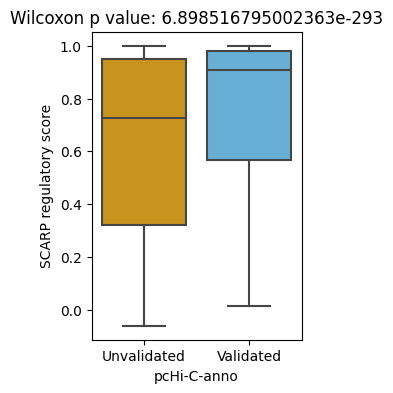

In [31]:
import scipy
stat, pvalue = scipy.stats.ranksums(plot_data_promoter_all_peak[plot_data_promoter_all_peak['pcHi-C-anno'] == 'Unvalidated']['SCARP regulatory score'],
                                    plot_data_promoter_all_peak[plot_data_promoter_all_peak['pcHi-C-anno'] == 'Validated']['SCARP regulatory score'])
plt.figure(2, figsize=(3, 4))
sns.boxplot(data=plot_data_promoter_all_peak,
                  x='pcHi-C-anno', y='SCARP regulatory score',
                  palette=['#E59F01', '#56B4E8'],
                  fliersize=1,
                  whis=2)
plt.title('Wilcoxon p value: ' + str(pvalue))
plt.subplots_adjust(left=0.2)
plt.savefig('./Results/Wilcoxon-test-pcHi-C-Unvalidated-or-validated.svg')
plt.show()

In [32]:
fpr_scarp, tpr_scarp, threshold_scarp = roc_curve(
    plot_data_promoter_all_peak['pcHi-C'],
    plot_data_promoter_all_peak['SCARP regulatory score'])
roc_auc_scarp = auc(fpr_scarp, tpr_scarp)

fpr_ori, tpr_ori, threshold_ori = roc_curve(
    plot_data_promoter_all_peak['pcHi-C'],
    plot_data_promoter_all_peak['original regulatory score'])
roc_auc_ori = auc(fpr_ori, tpr_ori)

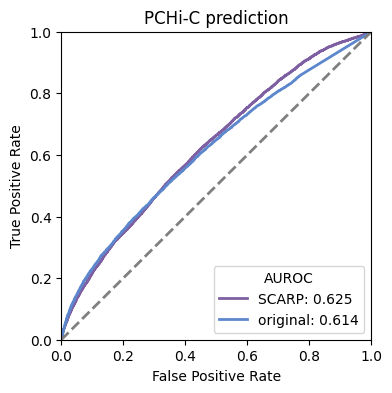

In [33]:
plt.figure(figsize=(4, 4))
plt.plot(fpr_scarp, tpr_scarp, color='#7E60A2',
         lw=2, label='SCARP: ' + str(np.around(roc_auc_scarp, 3)))
plt.plot(fpr_ori, tpr_ori, color='#5C87CC',
         lw=2, label='original: ' + str(np.around(roc_auc_ori, 3)))
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('PCHi-C prediction')
plt.legend(title='AUROC', loc="lower right")
plt.savefig('./Results/AUROC.svg')
plt.show()